# Image Captioning using Deep Learning: Assignment-3

*  In this assignment, we will use CNNs in [PyTorch](https://pytorch.org/docs/stable/index.html) for image classification.

* We have been using MNIST by flattening 28$\times$28 images to 784-sized vectors.

* This time, we will classify images from the CIFAR-10 dataset - dimension is 32$\times$32.

* Much of this notebook remains the same as for Assignment 2, just minor changes would be needed and this assignment won't take long.

**Feel free to redefine any pre-written cells below, just make sure to properly explain your work in Markdown and don't change the dataset**

## Import libraries here
PyTorch, NumPy, Matplotlib, ...
Even when equipped with PyTorch, NumPy and Matplotlib make your work easier for visualization etc.

Note the following method to **initialize the seed** for reproducibility of results, both for NumPy & PyTorch (CPU/CUDA).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn
%matplotlib inline

import random

import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
def set_seed(seed=42):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    # np.random.seed(seed)
    # torch.manual_seed(seed)
    # torch.cuda.manual_seed(seed)
    # # When running on the CuDNN backend, two further options must be set
    # torch.backends.cudnn.deterministic = True
    # torch.backends.cudnn.benchmark = False
    # # Set a fixed value for the hash seed
    # os.environ['PYTHONHASHSEED'] = str(seed)
    
set_seed(42)

## Load *Dataset*
**DON'T CHANGE THIS CODE**.

In [3]:
import torchvision
from torchvision import transforms, datasets

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

data_path = './'

train = datasets.CIFAR10(data_path, train=True, download=True, transform=transform)

test = datasets.CIFAR10(data_path, train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


# Your Code from here...

In [4]:
#from torch.utils.data import random_split
#train_ds, val_ds = random_split(train, [45000,5000])

#from torch.utils.data import DataLoader
#train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
#val_loader = DataLoader(val_ds, batch_size=64)

In [5]:
# load the data set
from torch.utils.data import DataLoader
X = DataLoader(train, batch_size=64, shuffle=True)
y = DataLoader(test, batch_size=64, shuffle=True)

# Split into X_train, y_train, X_test, y_test
# you can use stratified splitting from sklearn library
# Extract data and labels
X_train = train.data
y_train = train.targets
X_test = test.data
y_test = test.targets

# Convert data to float and normalize it
X_train = X_train / 255
X_test = X_test / 255


In [6]:
X_train[0]

array([[[0.23137255, 0.24313725, 0.24705882],
        [0.16862745, 0.18039216, 0.17647059],
        [0.19607843, 0.18823529, 0.16862745],
        ...,
        [0.61960784, 0.51764706, 0.42352941],
        [0.59607843, 0.49019608, 0.4       ],
        [0.58039216, 0.48627451, 0.40392157]],

       [[0.0627451 , 0.07843137, 0.07843137],
        [0.        , 0.        , 0.        ],
        [0.07058824, 0.03137255, 0.        ],
        ...,
        [0.48235294, 0.34509804, 0.21568627],
        [0.46666667, 0.3254902 , 0.19607843],
        [0.47843137, 0.34117647, 0.22352941]],

       [[0.09803922, 0.09411765, 0.08235294],
        [0.0627451 , 0.02745098, 0.        ],
        [0.19215686, 0.10588235, 0.03137255],
        ...,
        [0.4627451 , 0.32941176, 0.19607843],
        [0.47058824, 0.32941176, 0.19607843],
        [0.42745098, 0.28627451, 0.16470588]],

       ...,

       [[0.81568627, 0.66666667, 0.37647059],
        [0.78823529, 0.6       , 0.13333333],
        [0.77647059, 0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


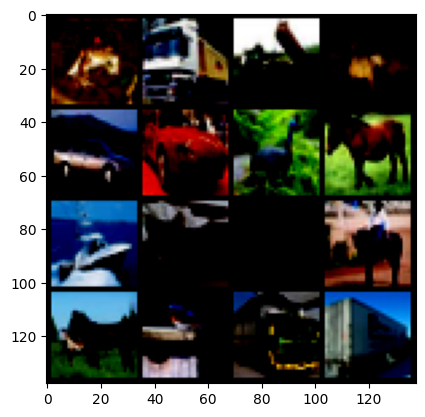

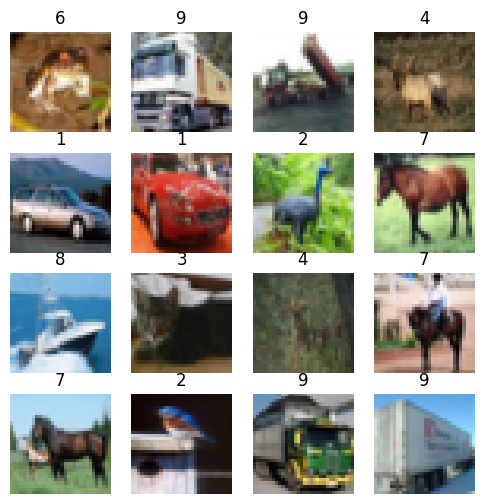

In [7]:
# display a 4x4 grid, 
from torchvision.utils import make_grid
# Select the first 16 images from the dataset
images = [train[i][0] for i in range(16)]
labels = [train[i][1] for i in range(16)]
# Create a grid of images using make_grid
grid = make_grid(images, nrow=4)
# Display the grid
plt.imshow(grid.permute(1, 2, 0))
plt.show()

# choose 16 images randomly, display the images as well as corresponding labels
# Select 16 images from the dataset
images = train.data[:16]
# Create a figure with a 4x4 grid of subplots
fig, axes = plt.subplots(4, 4, figsize=(6, 6))

# Plot the images in the subplots
for i, ax in enumerate(axes.flat):
    ax.imshow(images[i], cmap='gray')
    ax.set_title(labels[i])
    ax.axis('off')

# Display the figure
plt.show()

## ```nn.Module``` for your model
In this segment, define a class for your model, it has to inherit from the ```nn.Module``` class. You must define two functions here - ```__init__``` and ```forward```, again pretty self-explanatory. Helper functions can also be implemented, your choice!

Look into the following ```torch``` layers beyond those you used in the second assignment and combine them to form your network, you can find more [here](https://pytorch.org/docs/stable/nn.html) -
- [```nn.Conv2d```](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html)
- [```nn.BatchNorm2d```](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html)


In [8]:
# define a child class of nn.Module for your model
# specify the architecture here itself

class CNVnet(nn.Module):
    def __init__(self):
        super(CNVnet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x



## Training loop
You can write a training loop but usually writing it within a function helps so that you can train in multiple passes with just one function call if you still don't see convergence of the loss. ```display_step``` is for you to display results on the validation set (which you must not have trained upon).

You will need to use ```zero_grad()```, ```backward()``` and multiple such functions here. Look for them in the tutorials given.

In [9]:
def train(model, optimizer, criterion, train_loader, display_step=None):
    for epoch in range(10):
        for i, (X_train, y_train) in enumerate(train_loader):
            optimizer.zero_grad()
            y_pred = model(X_train)
            loss = criterion(y_pred, y_train)
            loss.backward()
            optimizer.step()
    

## Prediction & Accuracy
Prediction function should predict outputs using your trained model for a given **NumPy array** ```X_test``` and the output should be another **NumPy array**.

The accuracy function would be the same as before.

In [10]:
def predict(model, X_test):
    # Convert the input data to a PyTorch tensor
    X_test = torch.from_numpy(X_test).float()
    # Normalize the data
    X_test = X_test/255
    # Perform the forward pass
    with torch.no_grad():
        output = model(X_test)
    # Convert the output data to a NumPy array
    output = output.numpy()
    return output

In [11]:
def accuracy(pred, labels):
    # Convert predictions to numpy array
    predictions = pred.detach().numpy()
    labels = labels.detach().numpy()
    # Get the index of the max value for each sample
    predicted_labels = np.argmax(predictions, axis=1)
    # Calculate the number of correct predictions
    correct = (predicted_labels == labels).sum()
    # Calculate the accuracy
    acc = correct / len(labels)
    return acc

## Actually training your model
- Create a model, initialize it. Define optimizer for the model as well as loss criterion (you can actually set the seed here again, just in case you did some ```rand``` calls above for testing your functions).
- Define an instance of the dataset class, wrap it in a dataloader.
- Call the train function and train your model!


In [12]:
import torch.optim as optim
model = CNVnet()
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

train(model, optimizer, criterion, X, display_step=None)

## Run your model for the validation dataset
Use your trained model to get predictions for the validation dataset you split earlier.

In [13]:
# From: [batch_size, height, width, channels]
# To: [batch_size, channels, height, width]
X_test = torch.from_numpy(X_test)
X_test = X_test.permute(0,3,1,2)
X_test = X_test.numpy()
predict(model, X_test)

array([[-0.23885213, -4.6070266 ,  1.3200186 , ..., -3.727256  ,
         0.19199434, -3.3203344 ],
       [-0.23230758, -4.601978  ,  1.3206371 , ..., -3.722862  ,
         0.19571033, -3.3078368 ],
       [-0.22991668, -4.60242   ,  1.3200732 , ..., -3.7237937 ,
         0.20159718, -3.3085992 ],
       ...,
       [-0.23767647, -4.6051397 ,  1.3171582 , ..., -3.7243385 ,
         0.20203608, -3.3121688 ],
       [-0.24495967, -4.603078  ,  1.3156459 , ..., -3.7179878 ,
         0.1897972 , -3.314151  ],
       [-0.23965065, -4.5998497 ,  1.3142316 , ..., -3.7183306 ,
         0.19647926, -3.309273  ]], dtype=float32)

## Submission
To submit your solution, you will need to make a file with name ```model.py``` containing imports necessary to write the model class and the model class itself. It shouldn't do anything else when run. Other than this, save the trained model in a file named ```ass_3.pt```. When you are done with the assignment, commit the updated notebook, the ```model.py``` class file and the ```ass_3.pt``` model-weights file to the repository.

In [14]:
torch.save(model, "ass_3.pt")

In [15]:
#from google.colab import files
#torch.save(final_model, 'ass_3.pt')
#files.download('ass_3.pt') # download the file from the Colab session for submission

Check if it got saved right!

In [16]:
# load the model, use predict function
